### Statistical Model to Predict Match Outcomes

The aim of the project to build a web app that predicts football match results of 2023/24 season using poisson distribution model. 

The web app is a Streamlit dashboard that can be used to predict English Premier League match results using Poisson distribution model.

The goal is to build a statistical model that predicts football match results.
In order to do that, the following steps were taken.

- Webscrap English Premier League dataset from a football data provider.
- Compare the odds given by the bookmakers to the odds obtained by the model with the objective of finding a market that is undervalued.


### Import Packages

In [78]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns 
import matplotlib.pyplot as plt 
import streamlit as st

###  Webscrapping Football Data 

The dataset is a live English Premier league standings, fixtures and scores table. For this project dataset was scraped from [Fbref.](https://fbref.com/en/)

In [77]:
url='https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures'
ligue_list = []

ligue_list.append(pd.read_html(url,index_col=False,flavor='lxml')[0])
ligue_list = pd.concat(ligue_list, axis=0, ignore_index=True)
pl_df = ligue_list[ligue_list['Wk'].notna()] # drop na

pl_df.head()

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,Match Report,NaN
1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,Match Report,NaN
2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,Match Report,NaN
3,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,Match Report,NaN
4,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,Match Report,NaN


### Feature Engineering

In [79]:
pl_df=pl_df.rename(columns={'Home':'HomeTeam','Away':'AwayTeam'})
pl_df=pl_df.rename(columns={'xG':'XGHome','xG.1':'XGAway'})
pl_df['HomeGoals'] = pl_df['Score'].str[0]
pl_df['AwayGoals'] = pl_df['Score'].str[2]
pl_df=pl_df[['Date', 'Time','HomeTeam', 'AwayTeam','XGHome', 'Score', 'XGAway','HomeGoals','AwayGoals']].reset_index(drop=True)


In [80]:
pl_df

,Date,Time,HomeTeam,AwayTeam,XGHome,Score,XGAway,HomeGoals,AwayGoals
0,2023-08-11,20:00,Burnley,Manchester City,0.3,0–3,1.9,0,3
1,2023-08-12,12:30,Arsenal,Nott'ham Forest,0.8,2–1,1.2,2,1
2,2023-08-12,15:00,Everton,Fulham,2.7,0–1,1.5,0,1
3,2023-08-12,15:00,Sheffield Utd,Crystal Palace,0.5,0–1,1.9,0,1
4,2023-08-12,15:00,Brighton,Luton Town,4.0,4–1,1.5,4,1
...,...,...,...,...,...,...,...,...,...
375,2024-05-19,NaN,Brentford,Newcastle Utd,NaN,NaN,NaN,NaN,NaN
376,2024-05-19,NaN,Chelsea,Bournemouth,NaN,NaN,NaN,NaN,NaN
377,2024-05-19,NaN,Crystal Palace,Aston Villa,NaN,NaN,NaN,NaN,NaN
378,2024-05-19,NaN,Liverpool,Wolves,NaN,NaN,NaN,NaN,NaN


In [81]:
df = pd.concat([pl_df[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           pl_df[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

In [82]:
df.tail()

,team,opponent,goals,home
375,Newcastle Utd,Brentford,NaN,0
376,Bournemouth,Chelsea,NaN,0
377,Aston Villa,Crystal Palace,NaN,0
378,Wolves,Liverpool,NaN,0
379,Nott'ham Forest,Burnley,NaN,0


There are 'NaN'values in the data. These are matches that have not been played it and should be removed.

In [83]:
df = df.dropna()

In [85]:
df.shape

(260, 4)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 129
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   team      260 non-null    object
 1   opponent  260 non-null    object
 2   goals     260 non-null    object
 3   home      260 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 10.2+ KB


The column 'goals' data type should be integer rather than a string 

In [88]:
df['goals'] = df['goals'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 129
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   team      260 non-null    object
 1   opponent  260 non-null    object
 2   goals     260 non-null    int64 
 3   home      260 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 10.2+ KB


In [89]:
df.head()

,team,opponent,goals,home
0,Burnley,Manchester City,0,1
1,Arsenal,Nott'ham Forest,2,1
2,Everton,Fulham,0,1
3,Sheffield Utd,Crystal Palace,0,1
4,Brighton,Luton Town,4,1


### Build a Statistical Model

The **Poisson distribution** is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space. The poisson distribution considers the events occur at a constant mean rate and assume the events occur independently.

Poisson regression is a statistical model that can be used to model count data, which makes it very well suited to predict the number of goals scored a team scores in a football match.

In [90]:
# building the poisson model
formula = 'goals ~ team + opponent + home'
model = smf.glm(formula=formula, data=df, family=sm.families.Poisson()).fit()

In [91]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  260
Model:                            GLM   Df Residuals:                      220
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -364.07
Date:                Thu, 30 Nov 2023   Deviance:                       216.89
Time:                        16:21:43   Pearson chi2:                     183.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2912
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.0268      0.383     -0.070      0.944      -0.777       0.724
team[T.Aston Villa]             0.1807      0.270      0.670      0.503      -0.348       0.709
team[T.Bournemouth]            -0.5978      0.334     -1.790      0.073      -1.252       0.057
team[T.Brentford]              -0.2702      0.303     -0.893      0.372      -0.863       0.323
team[T.Brighton]                0.0739      0.275      0.268      0.788      -0.466       0.614
team[T.Burnley]                -0.8644      0.374     -2.309      0.021      -1.598      -0.131
team[T.Chelsea]                -0.0820      0.293     -0.280      0.780      -0.657       0.493
team[T.Crystal Palace]         -0.6962      0.341     -2.042      0.041      -1.365      -0.028
team[T.Everton]                -0.6353      0.335     -1.894      0.058      -1.293       0.022
team[T.Fulham]                 -0.6801      0.342     -1.987      0.047      -1.351      -0.009
team[T.Liverpool]               0.0995      0.277      0.359      0.719      -0.443       0.642
team[T.Luton Town]             -0.7627      0.351     -2.171      0.030      -1.451      -0.074
team[T.Manchester City]         0.2371      0.265      0.895      0.371      -0.282       0.756
team[T.Manchester Utd]         -0.5300      0.319     -1.660      0.097      -1.156       0.096
team[T.Newcastle Utd]           0.1717      0.270      0.636      0.524      -0.357       0.700
team[T.Nott'ham Forest]        -0.4794      0.321     -1.494      0.135      -1.108       0.150
team[T.Sheffield Utd]          -0.8066      0.362     -2.230      0.026      -1.516      -0.098
team[T.Tottenham]              -0.0492      0.282     -0.174      0.862      -0.603       0.504
team[T.West Ham]               -0.1251      0.288     -0.435      0.664      -0.690       0.439
team[T.Wolves]                 -0.3143      0.309     -1.016      0.310      -0.921       0.292
opponent[T.Aston Villa]         0.4962      0.399      1.244      0.214      -0.286       1.278
opponent[T.Bournemouth]         0.8355      0.372      2.243      0.025       0.106       1.565
opponent[T.Brentford]           0.5292      0.397      1.332      0.183      -0.250       1.308
opponent[T.Brighton]            0.7457      0.384      1.944      0.052      -0.006       1.498
opponent[T.Burnley]             1.0122      0.365      2.771      0.006       0.296       1.728
opponent[T.Chelsea]             0.5418      0.391      1.385      0.166      -0.225       1.309
opponent[T.Crystal Palace]      0.5590      0.398      1.403      0.161      -0.222       1.340
opponent[T.Everton]             0.6307      0.395      1.598      0.110      -0.143       1.404
opponent[T.Fulham]              0.6385      0.386      1.653      0.098      -0.119       1.396
opponent[T.

In [60]:
np.exp(0.2063)

1.2291218852559347

The home teams generally score more goals (1.23 times more likely) than the away team as can be seen from the model summary.

Let’s start making some predictions for the upcoming matches. We need to input the teams into the model and it returns the expected average number of goals for the teams

Let's start with the weekend's two games 
- **Liverpool Vs Fulham**
- **Brentford Vs Luton Town**

and then coompare the poisson model odds we built with a bookmakers odds. The model above can be used to compare results for any game. 

In [92]:
# predicting the scores
model.predict(pd.DataFrame(data={'team': 'Liverpool', 'opponent': 'Fulham',
                                       'home':1},index=[1]))

1    2.503062
dtype: float64

In [93]:
model.predict(pd.DataFrame(data={'team': 'Fulham', 'opponent': 'Liverpool',
                                       'home':0},index=[1]))

1    0.440261
dtype: float64

In [94]:
#np.sum(np.diag(liverpool_fulham)) # Probability Draw
#np.sum(np.triu(liverpool_fulham, 1)) # The probabilty that Fulham win
#np.sum(np.tril(liverpool_fulham, -1)) # The probability that Liverpool win

There is only a 4.2% chance of Fulham winning the game according to the poisson model while Liverpool has an 82.7/% chance of winning

Let's simulate the model for any matches with the number of goals each team scores can range from 0 to 5 

In [95]:
def future_match(football_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = football_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = football_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), (np.array(team_pred[1]))))

In [96]:
future_match(model,'Liverpool','Fulham',max_goals=5)

array([[5.26903071e-02, 2.31975117e-02, 5.10648524e-03, 7.49396222e-04,
        8.24825694e-05, 7.26277936e-06],
       [1.31887121e-01, 5.80648171e-02, 1.27818507e-02, 1.87578543e-03,
        2.06459010e-04, 1.81791892e-05],
       [1.65060841e-01, 7.26699274e-02, 1.59968843e-02, 2.34760390e-03,
        2.58389883e-04, 2.27518216e-05],
       [1.37719189e-01, 6.06324520e-02, 1.33470660e-02, 1.95873294e-03,
        2.15588658e-04, 1.89830757e-05],
       [8.61799279e-02, 3.79417012e-02, 8.35213446e-03, 1.22570765e-03,
        1.34907961e-04, 1.18789553e-05],
       [4.31427458e-02, 1.89940884e-02, 4.18118258e-03, 6.13604522e-04,
        6.75366063e-05, 5.94675303e-06]])

The matrix shows the probability of Liverpool (row) and Fulham (matrix columns) scoring a specific number of goals. For example, along the diagonal, both teams score the same the number of goals (e.g. P(0-0)=0.0614).

##### Score Probability Matrix

In [97]:
homeTeam='Brentford'
awayTeam='Luton Town'
max_goals=5
score_matrix=future_match(model,homeTeam,awayTeam,max_goals=5)

Plot the score probabilty matrix

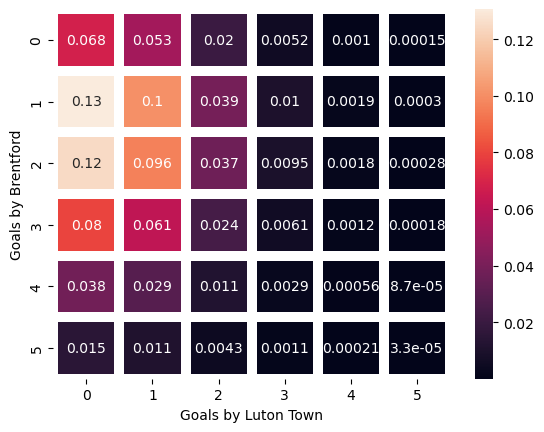

In [98]:
ax=sns.heatmap(score_matrix,linewidths=7,annot=True)
ax.set_xlabel('Goals by ' +  str(awayTeam))
ax.set_ylabel('Goals by ' +  str(homeTeam))
plt.show()

The most likely scoreline between Brentford and Luton is 1-0 or 2-0 Brentford win(with a combined 25%).

Home win,draw or away win probabilities and odds can be calculated as follows:

In [73]:
home_win=np.sum(np.tril(score_matrix,-1))
away_win=np.sum(np.triu(score_matrix,1))
draw=np.sum(np.diag(score_matrix))
print(homeTeam + ' win probability is ' + str(round(home_win*100,2)) + '%' )
print(awayTeam + ' win probability is ' + str(round(away_win*100,2)) + '%')
print('The probability of the two teams drawing the match is ' + str(round(draw*100,2)) + '%')

Brentford win probability is 63.01%
Luton Town win probability is 14.34%
The probability of the two teams drawing the match is 21.28%


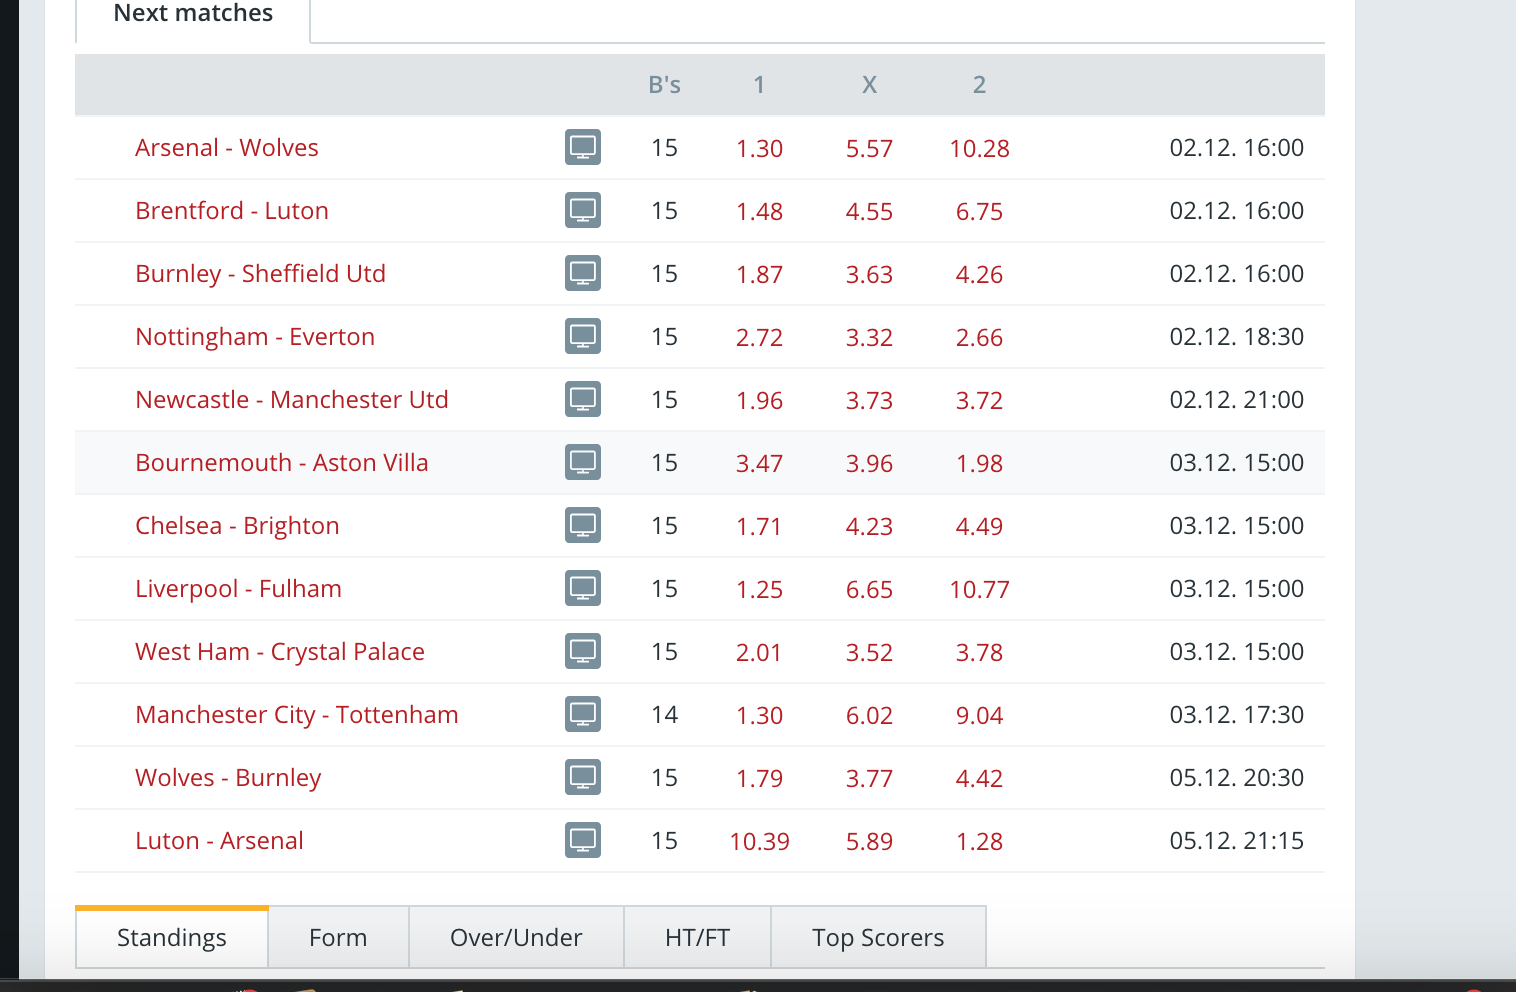

As we can see in the latest bets provided by a bookmaker, The bookies have 21.97% chance of a draw while our model suggested more or less similar probability of a draw (21.28%).

Brentford has an 67.5% (1/1.48) chance of winning the game which is very close to the odds we get from the poisson model

The rest of the project is building a web app to predict footballl match results. The web app is deployed on streamlit.

### Limitations 

Poisson model is a statistical model that offers estimated probabilities, not certainties. It needs to be fed more data to get a close to accurate prediction. No team in football performs the same in everygame throughout the season. There are up and downs. For instance, a team performance can be greatly affected by an injury to its key player.
Match prediction becomes better as the season goes longer since there will be more team individual players data available.

The poisson model I used here is a very simple one with limited features. The bookies use number of years of data, match sentiment, predicted lineups, and other complex machine learning algorithms to calculate chance of teams winning,losing or draw.